In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [2]:
# Load data
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
songs = pd.read_csv('./Data/songs.csv')
members = pd.read_csv('./Data/members.csv')
songs_extra = pd.read_csv('./Data/song_extra_info.csv')

In [3]:
# Preprocess members
members['bd'] = np.where(members['bd'] < 13, 12, members['bd'])
members['bd'] = np.where(members['bd'] > 74, 75, members['bd'])
members['registration_init_time'] = members['registration_init_time'].astype(str)
members['expiration_date'] = members['expiration_date'].astype(str)
members['reg_year'] = members['registration_init_time'].str[:4].astype(float)
members['reg_month'] = members['registration_init_time'].str[4:6].astype(float)
members['reg_day'] = members['registration_init_time'].str[6:8].astype(float)
members['exp_year'] = members['expiration_date'].str[:4].astype(float)
members['exp_month'] = members['expiration_date'].str[4:6].astype(float)
members['exp_day'] = members['expiration_date'].str[6:8].astype(float)
members.drop(['registration_init_time', 'expiration_date'], axis=1, inplace=True)

In [4]:
# Separate the 'genre_ids' column into separate columns g1, g2, g3, g4, g5, g6, g7, g8
genres = songs['genre_ids'].str.split('|', expand=True)
genres.columns = ['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8']

# Count the occurrences of each genre
g = genres.values.flatten()
g_counts = pd.Series(g).value_counts().sort_values(ascending=False)

# Extract the top 5 genres
pop_genre = g_counts.index[:5]

# Function to set the 'genres' column based on the presence of popular genres
def set_genre(x):
    if pd.Series(x).dropna().isin(pop_genre).any():
        return 'pop'
    else:
        return 'other'

# Apply the 'set_genre' function to each row of the 'genre' DataFrame
songs['genres'] = genres.apply(set_genre, axis=1)

# Remove the 'genre_ids' column from the 'songs' DataFrame
songs = songs.drop('genre_ids', axis=1)

In [5]:
# Preprocess songs_extra
def isrc_to_year(isrc):
    if pd.notnull(isrc):
        year = int(isrc[5:7])
        if year > 17:
            return 1900 + year
        else:
            return 2000 + year
    else:
        return None

songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis=1, inplace=True)
songs_extra['song_age'] = 2018 - songs_extra['song_year']

In [6]:
# Merge data
train = train.merge(members, on='msno', how='left')
train = train.merge(songs, on='song_id', how='left')
train = train.merge(songs_extra, on='song_id', how='left')

test = test.merge(members, on='msno', how='left')
test = test.merge(songs, on='song_id', how='left')
test = test.merge(songs_extra, on='song_id', how='left')

In [7]:
del members
del songs_extra
del songs
del pop_genre
del g_counts
del g
del genres
del isrc_to_year
del set_genre

In [8]:
# 合併
user_song = pd.concat([train[['msno','song_id']], test[['msno','song_id']]])
user_song.reset_index(drop=True, inplace=True)

# 建立稀疏矩陣
msno_values = user_song['msno'].astype('category').cat.codes
song_id_values = user_song['song_id'].astype('category').cat.codes
ms_sparse = coo_matrix((pd.Series(1, index=user_song.index), (msno_values, song_id_values)))
song_sparse = coo_matrix((pd.Series(1, index=user_song.index), ( song_id_values,msno_values)))
# 將稀疏矩陣轉換為樞紐表
ms_svd = pd.DataFrame.sparse.from_spmatrix(ms_sparse, index=user_song['msno'].unique(), columns=user_song['song_id'].unique())
song_svd = pd.DataFrame.sparse.from_spmatrix(song_sparse, index=user_song['song_id'].unique(), columns=user_song['msno'].unique())

# SVD
svd = TruncatedSVD(n_components=30)
svd.fit(ms_svd)
ms_svd = svd.transform(ms_svd)

svd = TruncatedSVD(n_components=30)
svd.fit(song_svd)
song_svd = svd.transform(song_svd)

In [9]:
del svd
del msno_values
del song_id_values
del ms_sparse
del song_sparse

In [10]:
ms_svd_c=['ms_1', 'ms_2', 'ms_3', 'ms_4', 'ms_5', 'ms_6', 'ms_7', 'ms_8', 'ms_9', 'ms_10',
          'ms_11', 'ms_12', 'ms_13', 'ms_14', 'ms_15', 'ms_16', 'ms_17', 'ms_18', 'ms_19', 'ms_20',
          'ms_21', 'ms_22', 'ms_23', 'ms_24', 'ms_25', 'ms_26', 'ms_27', 'ms_28', 'ms_29', 'ms_30']
song_svd_c=['song_1', 'song_2', 'song_3', 'song_4', 'song_5', 'song_6', 'song_7', 'song_8', 'song_9', 'song_10',
          'song_11', 'song_12', 'song_13', 'song_14', 'song_15', 'song_16', 'song_17', 'song_18', 'song_19', 'song_20',
          'song_21', 'song_22', 'song_23', 'song_24', 'song_25', 'song_26', 'song_27', 'song_28', 'song_29', 'song_30']

In [11]:
ms_svd = pd.DataFrame(ms_svd, index = user_song['msno'].unique(), columns=ms_svd_c)
song_svd = pd.DataFrame(song_svd, index = user_song['song_id'].unique(), columns= song_svd_c)

In [12]:
del user_song

In [13]:
train = train.merge(ms_svd, left_on = 'msno', right_index = True, how = 'left')
test = test.merge(ms_svd, left_on = 'msno', right_index = True, how = 'left')
del ms_svd
train = train.merge(song_svd, left_on ='song_id', right_index = True, how = 'left')
test = test.merge(song_svd, left_on ='song_id', right_index = True, how = 'left')
del song_svd

In [14]:
# Calculate user activity
user_activity_train = train['msno'].value_counts().reset_index()
user_activity_train.columns = ['msno', 'user_activity']
user_activity_test = test['msno'].value_counts().reset_index()
user_activity_test.columns = ['msno', 'user_activity']
user_activity = pd.concat([user_activity_train, user_activity_test]).drop_duplicates(subset='msno')

del user_activity_train
del user_activity_test

# Calculate number of times played
song_played_count_train = train['song_id'].value_counts().reset_index()
song_played_count_train.columns = ['song_id', 'number_of_time_played']
song_played_count_test = test['song_id'].value_counts().reset_index()
song_played_count_test.columns = ['song_id', 'number_of_time_played']
song_played_count = pd.concat([song_played_count_train, song_played_count_test]).drop_duplicates(subset='song_id')

del song_played_count_train
del song_played_count_test

# Merge user activity and song played count
train = train.merge(user_activity, on='msno', how='left')
test = test.merge(user_activity, on='msno', how='left')
del user_activity

train = train.merge(song_played_count, on='song_id', how='left')
test = test.merge(song_played_count, on='song_id', how='left')
del song_played_count

In [15]:
dot_c=['dot_1', 'dot_2', 'dot_3', 'dot_4', 'dot_5', 'dot_6', 'dot_7', 'dot_8', 'dot_9', 'dot_10',
          'dot_11', 'dot_12', 'dot_13', 'dot_14', 'dot_15', 'dot_16', 'dot_17', 'dot_18', 'dot_19', 'dot_20',
          'dot_21', 'dot_22', 'dot_23', 'dot_24', 'dot_25', 'dot_26', 'dot_27', 'dot_28', 'dot_29', 'dot_30']

In [16]:
train_ms_svd = train[ms_svd_c].values
train_song_svd = train[song_svd_c].values
train_dot = train_ms_svd * train_song_svd
train_dotsum = np.sum(np.multiply(train_ms_svd, train_song_svd), axis=1)

del train_ms_svd
del train_song_svd

In [17]:
train_dot = pd.DataFrame(train_dot, columns=dot_c)
train_dotsum = pd.DataFrame(train_dotsum, columns=['sumdot'])
train = pd.concat([train, train_dot, train_dotsum], axis=1)
del train_dotsum
del train_dot

In [19]:
test_ms_svd = test[ms_svd_c].values
test_song_svd = test[song_svd_c].values
test_dot = test_ms_svd * test_song_svd
test_dotsum = np.sum(np.multiply(test_ms_svd, test_song_svd), axis=1)
del test_ms_svd
del test_song_svd

In [20]:
test_dot = pd.DataFrame(test_dot, columns=dot_c)
test_dotsum = pd.DataFrame(test_dotsum, columns=['sumdot'])
test = pd.concat([test, test_dot, test_dotsum], axis=1)
del test_dotsum
del test_dot

In [24]:
del dot_c
del ms_svd_c
del song_svd_c

In [25]:
from sklearn.model_selection import train_test_split

# Prepare data for training
X = train.drop(['target'], axis=1)
y = train['target']
X_test = test.drop(['id'], axis=1)
ids = test['id']

# Convert character columns to categorical features
char_columns = X.select_dtypes(include=['object']).columns
for col in char_columns:
    X[col] = X[col].astype('category')
    X_test[col] = X_test[col].astype('category')


In [31]:
del train
del test

In [26]:
# Split the train data into train and validation sets
train_data, val_data, train_target, val_target = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Create LightGBM datasets
lgb_train = lgb.Dataset(train_data, label=train_target)
lgb_val = lgb.Dataset(val_data, label=val_target, reference=lgb_train)

# Train the LightGBM model
evals_result = {} 
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.25,
    'num_leaves': 250,
    'bagging_fraction': 0.95,
    'bagging_freq': 1,
    'bagging_seed': 1,
    'feature_fraction': 0.9,
    'feature_fraction_seed': 1,
    'max_depth': -1,
    'num_rounds': 300,
}

kkbox = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val],
                  early_stopping_rounds=10,
                  evals_result=evals_result,
                  callbacks=[lgb.record_evaluation(evals_result)])

c:\Users\Aorus\.conda\envs\yolo\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Aorus\.conda\envs\yolo\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Aorus\.conda\envs\yolo\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 2971310, number of negative: 2930624
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.856010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67526
[LightGBM] [Info] Number of data points in the train set: 5901934, number of used features: 116


c:\Users\Aorus\.conda\envs\yolo\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Aorus\.conda\envs\yolo\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503447 -> initscore=0.013788
[LightGBM] [Info] Start training from score 0.013788


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

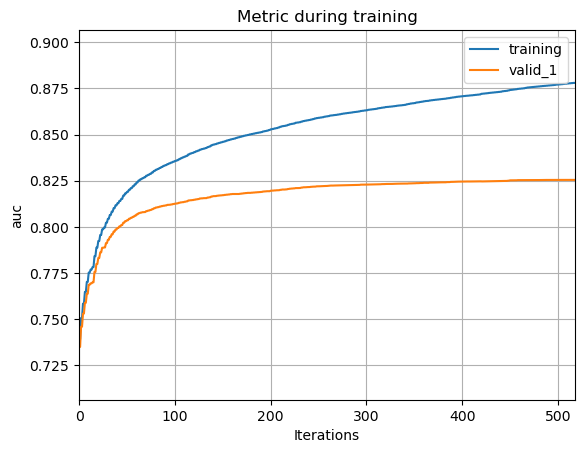

In [37]:
lgb.plot_metric(evals_result, metric='auc')

In [38]:
# Make predictions on the test data
test_predictions = kkbox.predict(X_test)

# Create submission file
subm = pd.DataFrame({'id': ids, 'target': test_predictions})
subm.to_csv('submission.csv', index=False)